In [5]:
import cdflib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import datetime as dt
from omni_seg import omni_seg
from gipm_transform_coeffs import gipm_transform_coeffs
from new_xyz import new_xyz
import glob
from math import pi
import math
from XMA_finder import XMA_finder
from histo_plot import histo_plot
from gipm_locs_quick import gipm_locs_quick

In [2]:
#open OMNI CSVs
list_all = []

path = "/Users/apx059/Documents/Location Only Checks/OMNI Raw/**"

for path in glob.glob(path, recursive=True):
    list_all.append(path)
    
#list with only files, not folders
om_csvs = []

for element in list_all:
    if '.csv' in element:
        om_csvs.append(element)
        
om_dfs = []

for element in om_csvs:
    om = pd.read_csv(element)
    om_dfs.append(om)
    
omni_all = pd.concat(om_dfs)
omni_all['datetime'] = pd.to_datetime(omni_all['datetime'])

omni_all = omni_all.set_index('datetime')

for element in om_dfs:
    element['datetime'] = pd.to_datetime(element['datetime'])
    element = element.set_index('datetime', inplace = True)


In [ ]:
##now to produce OMNI histograms of conditions
IMF_B = omni_all['B_mag']
SW_V = omni_all['V_gse']
N_p = omni_all['Np']
M_A = omni_all['M_A']
Cone_A = omni_all['cone angle']

fig = plt.figure(figsize=(6, 9), tight_layout=True)
gs = gridspec.GridSpec(3, 2)

ax = fig.add_subplot(gs[0,0])
#bins = [0,10,20,30,40,50,60,70,80,90]
ax.hist(IMF_B, bins = [0,1,2,4,6,8,10,12,14,16,18,22,26,30,40,50,60,70], edgecolor='black', linewidth=1.2, density = False)
ax.set_xlabel("IMF B, nT (OMNI)")
ax.set_ylabel("No. Observations")
ax.set_xscale('log')
ax.set_yscale('log')

fig.suptitle('Solar Wind Conditions Feb 2001- Feb 2024')

ax = fig.add_subplot(gs[0,1])
ax.hist(SW_V, edgecolor='black', linewidth=1.2, density = False)
ax.set_xlabel("Solar Wind Speed, km/s (OMNI)")
ax.set_ylabel("No. Observations")
#ax.set_xscale('log')
ax.set_yscale('log')

ax = fig.add_subplot(gs[1,0])
ax.hist(M_A, bins = [1,2,3,4,5,6,7,8,10,12,14,16,18,20,25,30,40,50,70,100,200,400], edgecolor='black', linewidth=1.2, density = False)
ax.set_xlabel("Alfven Mach Number(OMNI)")
ax.set_ylabel("No. Observations")
ax.set_xscale('log')
ax.set_yscale('log')

ax = fig.add_subplot(gs[1,1])
#bins = [0,10,20,30,40,50,60,70,80,90]
ax.hist(N_p, bins = [0,1,2,4,6,8,10,12,14,16,18,22,26,30,40,50,60,70], edgecolor='black', linewidth=1.2, density = False)
ax.set_xlabel("Proton Density, /CC (OMNI)")
ax.set_ylabel("No. Observations")
ax.set_xscale('log')
ax.set_yscale('log')

ax = fig.add_subplot(gs[2,1])
#bins = [0,10,20,30,40,50,60,70,80,90]
ax.hist(Cone_A,bins = [0,10,20,30,40,50,60,70,80,90], edgecolor='black', linewidth=1.2, density = False)
ax.set_xlabel("IMF Cone Angle (OMNI)")
ax.set_ylabel("No. Observations")
#ax.set_xscale('log')
ax.set_yscale('log')

#fig.show()


In [6]:
##load Cluster CSVs

list_all = []

path = "/Users/apx059/Documents/Location Only Checks/Cluster Raw/**"

for path in glob.glob(path, recursive=True):
    list_all.append(path)
    
#list with only files, not folders
cl_file_list = []

for element in list_all:
    if '.csv' in element:
        cl_file_list.append(element)

cl_dfs = []

for file in cl_file_list:
    df = pd.read_csv(file,encoding='utf-8')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace = True)
    cl_dfs.append(df)

In [7]:
#need to reorder bc they're not automatically in the right order
reordered_om_df = []

for df in cl_dfs:
    fd_list = df.index
    fd = fd_list[0]
    first_read = fd.strftime("%Y")
    for omni_temp in om_dfs:
        fd_om_list_temp = omni_temp.index
        fd_om_temp = fd_om_list_temp[0]
        first_read_om_t = fd_om_temp.strftime("%Y")
        if first_read_om_t == first_read:
            reordered_om_df.append(omni_temp)

In [8]:
%%time
#break into intervals with averaged OMNI values. for subsequent GIPM plotting
#first, pair Cluster and OMNI dataframes

om_ave_list = []
dayside_cl_list = []

for df, om_df in zip(cl_dfs,reordered_om_df):
    #mask to just dayside
    cluster_df_day = df.loc[(df['X_gse']> 0)]
    datetime_list = cluster_df_day.index
    om_averages = omni_seg(om_df, datetime_list)
    om_ave_list.append(om_averages)
    dayside_cl_list.append(cluster_df_day)
    

CPU times: user 9h 48min 45s, sys: 2min 26s, total: 9h 51min 11s
Wall time: 9h 52min 53s


In [9]:
for om_ave_df in om_ave_list:
    CSV_path = '/Users/apx059/Documents/Location Only Checks/OMNI Averages'
    start_ind = om_ave_df.index[0]
    start_year = start_ind.strftime("%Y")
    start_year_int = int(start_year)
    end_year_int = start_year_int + 1
    end_year = str(end_year_int)
    CSV_file_name = CSV_path + 'OMNI' + '_Feb' + start_year + '_1yr' + '.csv'
    om_ave_df.to_csv(CSV_file_name)

df_no = 0
for cl_day in dayside_cl_list:
    CSV_path = '/Users/apx059/Documents/Location Only Checks/Cluster Dayside Only'
    df_ref = str(df_no)
    CSV_file_name = CSV_path + 'Cluster Dayside' + '_dfref' + df_ref +'.csv'
    cl_day.to_csv(CSV_file_name)
    df_no = df_no + 1


In [10]:
%%time
#find GIPM rotation matrices and scaling coefficient for every Cluster location
GIPM_mat_list = []
FAC_coeff_list = []

for om_df in om_ave_list:
    GIPM_mat, FAC_coeffs = gipm_transform_coeffs(om_df)
    GIPM_mat_list.append(GIPM_mat)
    FAC_coeff_list.append(FAC_coeffs)


CPU times: user 44min 3s, sys: 8min 14s, total: 52min 17s
Wall time: 56min 21s


In [11]:
%%time

Cluster_GIPM_locs_list = []

for i,j,k in zip(cl_dfs, GIPM_mat_list, FAC_coeff_list):
    Cluster_dt_loc = gipm_locs_quick(i, j, k)
    Cluster_GIPM_locs_list.append(Cluster_dt_loc)
    print('done!')

done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
done!
CPU times: user 13h 9min 38s, sys: 16min 13s, total: 13h 25min 52s
Wall time: 13h 32min 38s


In [12]:
%%time
#for df in Cluster_GIPM_locs_list
CSV_path = '/Users/apx059/Documents/Location Only Checks/Cluster GIPM/'
startref = 1
array_list = []

for df in Cluster_GIPM_locs_list:
    #formatting numpy array correctly
    list_loc = df['GIPM Loc'].tolist()
    array_loc = np.asarray(list_loc)
    list_time = df['datetime'].tolist()
    array_time = np.asarray(list_time)
    array_time = [[item] for item in array_time]
    array_both = np.append(array_time, array_loc, axis=1)
    array_list.append(array_both)
    #saving file
    ref = str(startref)
    start_year = list_time[0].strftime("%Y")
    start_year_int = int(start_year)
    end_year_int = start_year_int + 1
    end_year = str(end_year_int)
    filename = CSV_path + '_Feb' + start_year + '_Feb' + end_year + 'df_' + ref + '.csv'
    np.savetxt(filename,array_both, fmt='%s,%f,%f,%f')
    startref = startref + 1

CPU times: user 2min 36s, sys: 1min 51s, total: 4min 28s
Wall time: 5min 33s


In [13]:
#list of arrays. concatenate all
all_locs = np.concatenate(array_list, axis=0)
all_locs.shape

(24048511, 4)

In [14]:
#reference all X, Y, and Z

x_locs = all_locs[:,1]
y_locs = all_locs[:,2]
z_locs = all_locs[:,3]
##use numpy histogram to get actual bin numbers
x_bin_edges = range(30)
y_bin_edges = range(-30,30)
HistXY, xedg, yedg = np.histogram2d(x_locs, y_locs, bins=[x_bin_edges, y_bin_edges])
HistXY = HistXY.T

z_bin_edges = range(-30,30)
HistXZ, xedg, zedg = np.histogram2d(x_locs, z_locs, bins=[x_bin_edges, z_bin_edges])
HistXZ = HistXZ.T

HistXY[HistXY == 0] = np.nan
HistXZ[HistXZ == 0] = np.nan

In [15]:
##use numpy histogram to get actual bin numbers
x_bin_edges = np.arange(0.0, 30.0, 0.5)
y_bin_edges = np.arange(-30.0, 30.0, 0.5)
HistXY_05, xedg, yedg = np.histogram2d(x_locs, y_locs, bins=[x_bin_edges, y_bin_edges])
HistXY_05 = HistXY_05.T

z_bin_edges = np.arange(-30.0,30.0, 0.5)
HistXZ_05, xedg, zedg = np.histogram2d(x_locs, z_locs, bins=[x_bin_edges, z_bin_edges])
HistXZ_05 = HistXZ_05.T

HistXY_05[HistXY_05 == 0] = np.nan
HistXZ_05[HistXZ_05 == 0] = np.nan

In [16]:
omni_ave_all = pd.concat(om_ave_list)
XMA_all = XMA_finder(omni_ave_all)


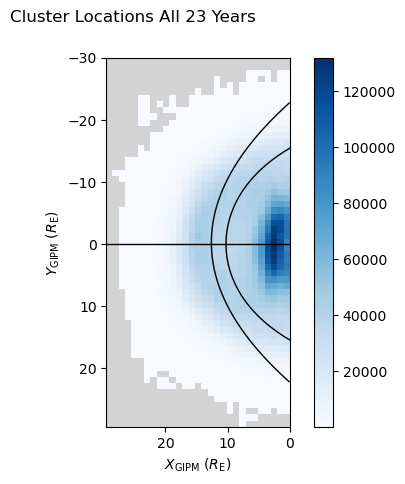

In [17]:
#import modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib import cm
import matplotlib
from merka05_surface_eq_array_GIPM import merka05_surface_eq_array_GIPM

x = np.linspace(0, 20, 100) #x coordinates (Re)
y = np.linspace(-30, 30, 100) #y coordinates (Re)
z = 0 #z coordinates in Re

[Xgipm,Ygipm,Zgipm] = np.meshgrid(x,y,z,indexing="ij")

fitting_coeffs = merka05_surface_eq_array_GIPM(XMA_all)

Xn = Xgipm
Yn = Ygipm
Zn = Zgipm
f = fitting_coeffs[0]*Xn**2 + fitting_coeffs[1]*Yn**2 + fitting_coeffs[2]*Zn**2+ 2*fitting_coeffs[3]*Xn*Yn + 2*fitting_coeffs[4]*Yn*Zn + 2*fitting_coeffs[5]*Xn*Zn + 2*fitting_coeffs[6]*Xn+2*fitting_coeffs[7]*Yn + 2*fitting_coeffs[8]*Zn + fitting_coeffs[9]

#tanfieldangle = y/x

tan_angle_0 = np.tan(np.deg2rad(15))
tan_angle_1 = np.tan(np.deg2rad(45))
tan_angle_2 = np.tan(np.deg2rad(75))

#magnetopause model, D = 2 nPa

m_1 = 10.22
m_2 = 1.29
m_3 = 0.184
m_4 = 8.14
m_5 = 6.6
m_6 = 0.58
m_7 = -0.007
m_8 = 0.024

#use B_z =0
B_z = 0
D_p = 2

alpha = (m_6 + m_7*B_z)*(1 +m_8*(np.log(D_p)))

tanh_angle = m_3*(B_z+m_4)
r_0 = (m_1 + m_2*np.tanh(tanh_angle))*(D_p**(-1/m_5))

pi = np.pi

theta = np.arange(-pi/2, pi/2, 0.01)

r_mod = (2/(1+np.cos(theta)))**alpha
r = r_0*r_mod

X_shue = r*(np.cos(theta))
R_shue = r*(np.sin(theta))


###################
fig, ax = plt.subplots()
#subfigs = fig.subfigures(1, 1)
#axsLeft = subfigs.subplots(1, 3, sharey=False)
#gs = gridspec.GridSpec(2, 2)
plt.suptitle('Cluster Locations All 23 Years')

ax.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax.plot(X_shue, R_shue, linewidth=1, color='k')

ax.set_aspect('equal')
ax.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


#want to find three points on the bow shock surface, at y=0 and y=±8 and draw lines from there
#without exceeding current bounds of plot
inter_med = fitting_coeffs[6]**2 - (fitting_coeffs[0]*fitting_coeffs[9])
X_BS_nose = (-fitting_coeffs[6] + np.sqrt(inter_med))/fitting_coeffs[0]

x_s = X_BS_nose
y_s = 0
x_e = 30
y_e = x_e*(-tan_angle_0)

#want to also have line for just solar wind flow along y=0

ax.hlines(y=0, xmin= 0, xmax=30, linewidth=1, color='k')
#ax.plot([x_s, x_e], [y_s, y_e], color='k',linewidth=1)
cmap = matplotlib.colormaps.get_cmap('Blues') 
cmap.set_bad(color='lightgrey')
plt.imshow(HistXY, interpolation='nearest', origin='lower', extent=[xedg[0], xedg[-1], yedg[0], yedg[-1]],cmap = cmap)
#ax.set_ylim(-30,30)
#ax.set_xlim(0,30)
ax.invert_xaxis()
ax.invert_yaxis()
plt.colorbar()

plt.show()

In [ ]:
x = np.linspace(0, 20, 100) #x coordinates (Re)
y = np.linspace(-30, 30, 100) #y coordinates (Re)
z = 0 #z coordinates in Re

[Xgipm,Ygipm,Zgipm] = np.meshgrid(x,y,z,indexing="ij")

fitting_coeffs = merka05_surface_eq_array_GIPM(XMA_all)

Xn = Xgipm
Yn = Ygipm
Zn = Zgipm
f = fitting_coeffs[0]*Xn**2 + fitting_coeffs[1]*Yn**2 + fitting_coeffs[2]*Zn**2+ 2*fitting_coeffs[3]*Xn*Yn + 2*fitting_coeffs[4]*Yn*Zn + 2*fitting_coeffs[5]*Xn*Zn + 2*fitting_coeffs[6]*Xn+2*fitting_coeffs[7]*Yn + 2*fitting_coeffs[8]*Zn + fitting_coeffs[9]

x_1 = np.linspace(0, 20, 100) #x coordinates (Re)
y_1 = 0 #y coordinates (Re)
z_1 = np.linspace(-30, 30, 100) #z coordinates in Re

[Xgipm_1,Ygipm_1,Zgipm_1] = np.meshgrid(x_1,y_1,z_1,indexing="ij")
Xn_1 = Xgipm_1
Yn_1 = Ygipm_1
Zn_1 = Zgipm_1
f_1 = fitting_coeffs[0]*Xn_1**2 + fitting_coeffs[1]*Yn_1**2 + fitting_coeffs[2]*Zn_1**2+ 2*fitting_coeffs[3]*Xn_1*Yn_1 + 2*fitting_coeffs[4]*Yn_1*Zn_1 + 2*fitting_coeffs[5]*Xn_1*Zn_1 + 2*fitting_coeffs[6]*Xn_1+2*fitting_coeffs[7]*Yn_1 + 2*fitting_coeffs[8]*Zn_1 + fitting_coeffs[9]

#magnetopause model, D = 2 nPa

m_1 = 10.22
m_2 = 1.29
m_3 = 0.184
m_4 = 8.14
m_5 = 6.6
m_6 = 0.58
m_7 = -0.007
m_8 = 0.024

#use B_z =0
B_z = 0
D_p = 2

alpha = (m_6 + m_7*B_z)*(1 +m_8*(np.log(D_p)))

tanh_angle = m_3*(B_z+m_4)
r_0 = (m_1 + m_2*np.tanh(tanh_angle))*(D_p**(-1/m_5))

pi = np.pi

theta = np.arange(-pi/2, pi/2, 0.01)

r_mod = (2/(1+np.cos(theta)))**alpha
r = r_0*r_mod

X_shue = r*(np.cos(theta))
R_shue = r*(np.sin(theta))


###################
fig, ax = plt.subplots()
subfigs = fig.subfigures(1, 1)
axsLeft = subfigs.subplots(1, 2, sharey=False)
subfigs.suptitle('Cluster Locations All 23 Years, 1RE bins')

ax0 = axsLeft[0]

ax0.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax0.plot(X_shue, R_shue, linewidth=1, color='k')

ax0.set_aspect('equal')
ax0.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax0.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


#want to find three points on the bow shock surface, at y=0 and y=±8 and draw lines from there
#without exceeding current bounds of plot
inter_med = fitting_coeffs[6]**2 - (fitting_coeffs[0]*fitting_coeffs[9])
X_BS_nose = (-fitting_coeffs[6] + np.sqrt(inter_med))/fitting_coeffs[0]

x_s = X_BS_nose
y_s = 0
x_e = 30
y_e = x_e*(-tan_angle_0)

#want to also have line for just solar wind flow along y=0

ax0.hlines(y=0, xmin= 0, xmax=30, linewidth=1, color='k')
#ax.plot([x_s, x_e], [y_s, y_e], color='k',linewidth=1)
cmap = matplotlib.colormaps.get_cmap('Blues') 
cmap.set_bad(color='lightgrey')
im = ax0.imshow(HistXY, interpolation='nearest', origin='lower', extent=[xedg[0], xedg[-1], yedg[0], yedg[-1]], vmax = 60_000, cmap = cmap)
#ax.set_ylim(-30,30)
#ax.set_xlim(0,30)
ax0.invert_xaxis()
ax0.invert_yaxis()
fig.colorbar(mappable=im,location='bottom',anchor=(0.5, 0), panchor=(0.5, 0.2), pad=0.1, ax=axsLeft, label='No. of Observations')

ax1 = axsLeft[1]

ax1.contour(Xgipm_1[:,0,:],Zgipm_1[:,0,:],f_1[:,0,:],levels = [0],colors="black",linewidths=1)
ax1.plot(X_shue, R_shue, linewidth=1, color='k')

ax1.set_aspect('equal')
ax1.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.set_ylabel("$Z_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


ax1.hlines(y=0, xmin= 0, xmax=30, linewidth=1, color='k')
#ax.plot([x_s, x_e], [y_s, y_e], color='k',linewidth=1)
ax1.imshow(HistXZ, interpolation='nearest', origin='lower', extent=[xedg[0], xedg[-1], yedg[0], yedg[-1]], vmax = 60_000, cmap = cmap)
#ax.set_ylim(-30,30)
#ax.set_xlim(0,30)
ax1.invert_xaxis()
ax1.invert_yaxis()
#fig.show()

In [ ]:
x = np.linspace(0, 20, 100) #x coordinates (Re)
y = np.linspace(-30, 30, 100) #y coordinates (Re)
z = 0 #z coordinates in Re

[Xgipm,Ygipm,Zgipm] = np.meshgrid(x,y,z,indexing="ij")

fitting_coeffs = merka05_surface_eq_array_GIPM(XMA_all)

Xn = Xgipm
Yn = Ygipm
Zn = Zgipm
f = fitting_coeffs[0]*Xn**2 + fitting_coeffs[1]*Yn**2 + fitting_coeffs[2]*Zn**2+ 2*fitting_coeffs[3]*Xn*Yn + 2*fitting_coeffs[4]*Yn*Zn + 2*fitting_coeffs[5]*Xn*Zn + 2*fitting_coeffs[6]*Xn+2*fitting_coeffs[7]*Yn + 2*fitting_coeffs[8]*Zn + fitting_coeffs[9]

x_1 = np.linspace(0, 20, 100) #x coordinates (Re)
y_1 = 0 #y coordinates (Re)
z_1 = np.linspace(-30, 30, 100) #z coordinates in Re

[Xgipm_1,Ygipm_1,Zgipm_1] = np.meshgrid(x_1,y_1,z_1,indexing="ij")
Xn_1 = Xgipm_1
Yn_1 = Ygipm_1
Zn_1 = Zgipm_1
f_1 = fitting_coeffs[0]*Xn_1**2 + fitting_coeffs[1]*Yn_1**2 + fitting_coeffs[2]*Zn_1**2+ 2*fitting_coeffs[3]*Xn_1*Yn_1 + 2*fitting_coeffs[4]*Yn_1*Zn_1 + 2*fitting_coeffs[5]*Xn_1*Zn_1 + 2*fitting_coeffs[6]*Xn_1+2*fitting_coeffs[7]*Yn_1 + 2*fitting_coeffs[8]*Zn_1 + fitting_coeffs[9]

#magnetopause model, D = 2 nPa

m_1 = 10.22
m_2 = 1.29
m_3 = 0.184
m_4 = 8.14
m_5 = 6.6
m_6 = 0.58
m_7 = -0.007
m_8 = 0.024

#use B_z =0
B_z = 0
D_p = 2

alpha = (m_6 + m_7*B_z)*(1 +m_8*(np.log(D_p)))

tanh_angle = m_3*(B_z+m_4)
r_0 = (m_1 + m_2*np.tanh(tanh_angle))*(D_p**(-1/m_5))

pi = np.pi

theta = np.arange(-pi/2, pi/2, 0.01)

r_mod = (2/(1+np.cos(theta)))**alpha
r = r_0*r_mod

X_shue = r*(np.cos(theta))
R_shue = r*(np.sin(theta))


###################
fig, ax = plt.subplots()
subfigs = fig.subfigures(1, 1)
axsLeft = subfigs.subplots(1, 2, sharey=False)
subfigs.suptitle('Cluster Locations All 23 Years, 0.5RE bins')

ax0 = axsLeft[0]

ax0.contour(Xgipm[:,:,0],Ygipm[:,:,0],f[:,:,0],levels = [0],colors="black",linewidths=1)
ax0.plot(X_shue, R_shue, linewidth=1, color='k')

ax0.set_aspect('equal')
ax0.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax0.set_ylabel("$Y_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


#want to find three points on the bow shock surface, at y=0 and y=±8 and draw lines from there
#without exceeding current bounds of plot
inter_med = fitting_coeffs[6]**2 - (fitting_coeffs[0]*fitting_coeffs[9])
X_BS_nose = (-fitting_coeffs[6] + np.sqrt(inter_med))/fitting_coeffs[0]

x_s = X_BS_nose
y_s = 0
x_e = 30
y_e = x_e*(-tan_angle_0)

#want to also have line for just solar wind flow along y=0

ax0.hlines(y=0, xmin= 0, xmax=30, linewidth=1, color='k')
#ax.plot([x_s, x_e], [y_s, y_e], color='k',linewidth=1)
cmap = matplotlib.colormaps.get_cmap('Blues') 
cmap.set_bad(color='lightgrey')
im = ax0.imshow(HistXY_05, interpolation='nearest', origin='lower', extent=[xedg[0], xedg[-1], yedg[0], yedg[-1]], vmax=10_000, cmap = cmap)
#ax.set_ylim(-30,30)
#ax.set_xlim(0,30)
ax0.invert_xaxis()
ax0.invert_yaxis()
fig.colorbar(mappable=im,location='bottom',anchor=(0.5, 0), panchor=(0.5, 0.2), pad=0.1, ax=axsLeft, label='No. of Observations')

ax1 = axsLeft[1]

ax1.contour(Xgipm_1[:,0,:],Zgipm_1[:,0,:],f_1[:,0,:],levels = [0],colors="black",linewidths=1)
ax1.plot(X_shue, R_shue, linewidth=1, color='k')

ax1.set_aspect('equal')
ax1.set_xlabel("$X_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")
ax1.set_ylabel("$Z_\\mathrm{GIPM}$ ($R_\\mathrm{E}$)")


ax1.hlines(y=0, xmin= 0, xmax=30, linewidth=1, color='k')
#ax.plot([x_s, x_e], [y_s, y_e], color='k',linewidth=1)
ax1.imshow(HistXZ_05, interpolation='nearest', origin='lower', extent=[xedg[0], xedg[-1], yedg[0], yedg[-1]], vmax=10_000, cmap = cmap)
#ax.set_ylim(-30,30)
#ax.set_xlim(0,30)
ax1.invert_xaxis()
ax1.invert_yaxis()
#fig.show()

In [ ]:
#mask to low Z

all_locs[all_locs[:, 3] > 5] = np.nan
all_locs[all_locs[:, 3] < -5] = np.nan

#drop datetime row bc numpy is bad at handling that
#and it doesn't matter right now
#and try numpy isnan again

all_locs_only = np.delete(all_locs,0,1)
all_locs_only

#convert remaining rows to 
all_locs_only = all_locs_only.astype('float64')
all_locs_low_z = (all_locs_only[~np.isnan(all_locs_only).any(axis=1), :])

In [ ]:
x_locs = all_locs_low_z[:,0]
y_locs = all_locs_low_z[:,1]
z_locs = all_locs_low_z[:,2]

##use numpy histogram to get actual bin numbers (1RE bins)
x_bin_edges = np.arange(0.0, 30.0, 1)
y_bin_edges = np.arange(-30.0, 30.0, 1)
HistXY_lowZ, xedg, yedg = np.histogram2d(x_locs, y_locs, bins=[x_bin_edges, y_bin_edges])
HistXY_lowZ = HistXY_lowZ.T

z_bin_edges = np.arange(-30.0,30.0, 1)
HistXZ_lowZ, xedg, zedg = np.histogram2d(x_locs, z_locs, bins=[x_bin_edges, z_bin_edges])
HistXZ_lowZ = HistXZ_lowZ.T

HistXY_lowZ[HistXY_lowZ == 0] = np.nan
HistXZ_lowZ[HistXZ_lowZ == 0] = np.nan

##use numpy histogram to get actual bin numbers (0.5 RE bins)
x_bin_edges = np.arange(0.0, 30.0, 0.5)
y_bin_edges = np.arange(-30.0, 30.0, 0.5)
HistXY_lowZ_05, xedg, yedg = np.histogram2d(x_locs, y_locs, bins=[x_bin_edges, y_bin_edges])
HistXY_lowZ_05 = HistXY_lowZ_05.T

z_bin_edges = np.arange(-30.0,30.0, 0.5)
HistXZ_lowZ_05, xedg, zedg = np.histogram2d(x_locs, z_locs, bins=[x_bin_edges, z_bin_edges])
HistXZ_lowZ_05 = HistXZ_lowZ_05.T

HistXY_lowZ_05[HistXY_lowZ_05 == 0] = np.nan
HistXZ_lowZ_05[HistXZ_lowZ_05 == 0] = np.nan

In [ ]:
histo_plot(HistXY_lowZ_05,HistXZ_lowZ_05, XMA_all, xedg, yedg, zedg, 'Cluster Locations All 23 Years, Low Z, 0.5RE bins')

In [ ]:
histo_plot(HistXY_lowZ,HistXZ_lowZ,'Cluster Locations All 23 Years, Low Z, 1RE bins')

In [ ]:
#split by cone angle